In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim
from sklearn.model_selection import train_test_split
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
print('Done')

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Done


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Ant_Thesis/data/train_data.csv')

In [ ]:
train = train.drop_duplicates()

In [ ]:
train.rename(columns = {'Sentiment':'sentiment'}, inplace = True)
#train.rename(columns = {'Tweet':'text'}, inplace = True)
train

,text,sentiment
0,Bitcoin is unfolding like the dot com crash ju...,Neutral
1,XEM Price is 0 00003330 0 00000044 BTC 0 28641...,Negative
2,RT Bitcoin daily snapshot 24hr CHANGE 6 4 OUTL...,Neutral
3,Dutch Court Finds Bitcoin A Legitimate Transfe...,Neutral
4,BTC STEEM AskRate 0 00024274 Bittrex STEEM STE...,Positive
...,...,...
20077,Ethereum based virtual collectible game develo...,Negative
20078,RT Two Hour Lull Update CryptoCompare Bitcoin ...,Neutral
20079,RT NowPlaying Put It on You by GP LosAngeles H...,Neutral
20080,Craig Wright files copyright registration for ...,Negative


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Ant_Thesis/data/test_data.csv')
test.head(15)

,text,sentiment
0,RT Bitcoin Price Falls As Markets React To FAL...,Negative
1,RT 1 terabyte block capacity is coming to Bitc...,Neutral
2,bitcoin Is Record Business Optimism A Contrari...,Neutral
3,If you want private transactions use a privacy...,Neutral
4,As Novo Expects Bitcoin To Kill Other Crypto A...,Negative
5,RT Free Bitcoin litecoin and many other coin m...,Positive
6,Your honesty is superb we would have liked to ...,Negative
7,The Real Stark Industries nashville Startups n...,Negative
8,Block 522613 Size 129 27 kb Fee 0 11 kb Price ...,Neutral
9,The Blockchain Platform that Makes Irritating ...,Negative


In [ ]:
test.rename(columns = {'Sentiment':'sentiment'}, inplace = True)

In [ ]:
#Let's get the dataset lenght
len(train)

20082

In [ ]:
#Is there any other different value than neutral, negative and positive?
train['sentiment'].unique()

array(['Neutral', 'Negative', 'Positive'], dtype=object)

In [ ]:
#How's distributed the dataset? Is it biased?
train.groupby('sentiment').nunique()

,text
sentiment,
Negative,5939
Neutral,7975
Positive,6168


In [ ]:
#Let's get the dataset lenght
len(test)

5021

In [ ]:
#Is there any other different value than neutral, negative and positive?
test['sentiment'].unique()

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [ ]:
#How's distributed the dataset? Is it biased?
test.groupby('sentiment').nunique()

,text
sentiment,
Negative,1511
Neutral,1940
Positive,1570


**Test Part**

# Data cleaning

Even when the dataset is a little bit biased, we'll keep it this way because the differences are not significant.

In [ ]:
#Let's keep only the columns that we're going to use
train = train[['text','sentiment']]
train

,text,sentiment
0,Bitcoin is unfolding like the dot com crash ju...,Neutral
1,XEM Price is 0 00003330 0 00000044 BTC 0 28641...,Negative
2,RT Bitcoin daily snapshot 24hr CHANGE 6 4 OUTL...,Neutral
3,Dutch Court Finds Bitcoin A Legitimate Transfe...,Neutral
4,BTC STEEM AskRate 0 00024274 Bittrex STEEM STE...,Positive
...,...,...
20077,Ethereum based virtual collectible game develo...,Negative
20078,RT Two Hour Lull Update CryptoCompare Bitcoin ...,Neutral
20079,RT NowPlaying Put It on You by GP LosAngeles H...,Neutral
20080,Craig Wright files copyright registration for ...,Negative


In [ ]:
#Is there any null value?
train["text"].isnull().sum()

0

In [ ]:
#Let's fill the only null value.
train["text"].fillna("No content", inplace = True)

In [ ]:
train = train.dropna()

In [ ]:
train = train.drop_duplicates()

In [ ]:
#Let's keep only the columns that we're going to use
test = test[['text','sentiment']]
test

,text,sentiment
0,RT Bitcoin Price Falls As Markets React To FAL...,Negative
1,RT 1 terabyte block capacity is coming to Bitc...,Neutral
2,bitcoin Is Record Business Optimism A Contrari...,Neutral
3,If you want private transactions use a privacy...,Neutral
4,As Novo Expects Bitcoin To Kill Other Crypto A...,Negative
...,...,...
5016,The Image MASSter Solo 101 Forensic Hard Drive...,Negative
5017,Buy Bitcoin Bitcoin Cash Monero Zcash or Litec...,Positive
5018,In April 2016 computer technicians at the Demo...,Neutral
5019,The Gentlemen of Crypto EP 129 Bitcoin Blackli...,Neutral


In [ ]:
#Is there any null value?
test["text"].isnull().sum()

0

### The next steps about data cleaning will be:

* Remove URLs from the tweets
* Tokenize text
* Remove emails
* Remove new lines characters
* Remove distracting single quotes
* Remove all punctuation signs
* Lowercase all text
* Detokenize text
* Convert list of texts to Numpy array

In [ ]:
def depure_data(data):
    
    #Removing URLs with a regular expression
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    # Remove Emails
    data = re.sub('\S*@\S*\s?', '', data)

    # Remove new line characters
    data = re.sub('\s+', ' ', data)

    # Remove distracting single quotes
    data = re.sub("\'", "", data)
        
    return data

In [ ]:
temp = []
#Splitting pd.Series to list
data_to_list = train['text'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(depure_data(data_to_list[i]))
list(temp[:5])

['Bitcoin is unfolding like the dot com crash just 15 times faster BTC USD BITCOIN',
 'XEM Price is 0 00003330 0 00000044 BTC 0 286412 0 00641 USD Market rank is 13 nem bitcoin blockchain',
 'RT Bitcoin daily snapshot 24hr CHANGE 6 4 OUTLOOK Cautiously bearish Bear doji reversal favors sell off But ve',
 'Dutch Court Finds Bitcoin A Legitimate Transferable Value XBT BTC Bitcoin',
 'BTC STEEM AskRate 0 00024274 Bittrex STEEM STEEM STEEM altcoin altcoins bitcoin FOLLOW for PROFIT']

In [ ]:
temp2 = []
#Splitting pd.Series to list
data_to_list = test['text'].values.tolist()
for i in range(len(data_to_list)):
    temp2.append(depure_data(data_to_list[i]))
list(temp2[:5])

['RT Bitcoin Price Falls As Markets React To FALSE Japan Binance Threat UPDATED',
 'RT 1 terabyte block capacity is coming to Bitcoin Cash and can work while maintaining enough decentralization Joahannes',
 'bitcoin Is Record Business Optimism A Contrarian Indicator',
 'If you want private transactions use a privacy coin Bitcoin doesn t need to be the worlds next payment sy',
 'As Novo Expects Bitcoin To Kill Other Crypto Assets Altseason StillExpected']

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        

data_words = list(sent_to_words(temp))

print(data_words[:10])

[['bitcoin', 'is', 'unfolding', 'like', 'the', 'dot', 'com', 'crash', 'just', 'times', 'faster', 'btc', 'usd', 'bitcoin'], ['xem', 'price', 'is', 'btc', 'usd', 'market', 'rank', 'is', 'nem', 'bitcoin', 'blockchain'], ['rt', 'bitcoin', 'daily', 'snapshot', 'hr', 'change', 'outlook', 'cautiously', 'bearish', 'bear', 'doji', 'reversal', 'favors', 'sell', 'off', 'but', 've'], ['dutch', 'court', 'finds', 'bitcoin', 'legitimate', 'transferable', 'value', 'xbt', 'btc', 'bitcoin'], ['btc', 'steem', 'askrate', 'bittrex', 'steem', 'steem', 'steem', 'altcoin', 'altcoins', 'bitcoin', 'follow', 'for', 'profit'], ['this', 'is', 'our', 'free', 'bitcoin', 'miner', 'pays', 'at', 'sathoshi'], ['bitcoin', 'basics', 'cryptocurrency', 'blockchain', 'and', 'the', 'new', 'digital', 'economy', 'digital', 'currency', 'cryptocurre', 'blockchain'], ['block', 'size', 'kb', 'fee', 'kb', 'price', 'bitcoin', 'btc', 'btc', 'xbt', 'xbt'], ['the', 'latest', 'the', 'aquilante', 'daily', 'thanks', 'to', 'cybersecurity', 

In [ ]:
test_words = list(sent_to_words(temp2))

print(test_words[:10])

[['rt', 'bitcoin', 'price', 'falls', 'as', 'markets', 'react', 'to', 'false', 'japan', 'binance', 'threat', 'updated'], ['rt', 'terabyte', 'block', 'capacity', 'is', 'coming', 'to', 'bitcoin', 'cash', 'and', 'can', 'work', 'while', 'maintaining', 'enough', 'joahannes'], ['bitcoin', 'is', 'record', 'business', 'optimism', 'contrarian', 'indicator'], ['if', 'you', 'want', 'private', 'transactions', 'use', 'privacy', 'coin', 'bitcoin', 'doesn', 'need', 'to', 'be', 'the', 'worlds', 'next', 'payment', 'sy'], ['as', 'novo', 'expects', 'bitcoin', 'to', 'kill', 'other', 'crypto', 'assets', 'altseason', 'stillexpected'], ['rt', 'free', 'bitcoin', 'litecoin', 'and', 'many', 'other', 'coin', 'mine', 'in', 'easy', 'way'], ['your', 'honesty', 'is', 'superb', 'we', 'would', 'have', 'liked', 'to', 'have', 'been', 'mooning', 'but', 'the', 'reality', 'is', 'years', 'jeez', 'people', 'bitcoin', 'took', 'years', 'lets', 'just', 'relax', 'we', 'are', 'onto', 'winner'], ['the', 'real', 'stark', 'industries

In [ ]:
len(data_words)

20082

In [ ]:
len(test_words)

5021

In [ ]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [ ]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['bitcoin is unfolding like the dot com crash just times faster btc usd bitcoin', 'xem price is btc usd market rank is nem bitcoin blockchain', 'rt bitcoin daily snapshot hr change outlook cautiously bearish bear doji reversal favors sell off but ve', 'dutch court finds bitcoin legitimate transferable value xbt btc bitcoin', 'btc steem askrate bittrex steem steem steem altcoin altcoins bitcoin follow for profit']


In [ ]:
data2 = []
for i in range(len(test_words)):
    data2.append(detokenize(test_words[i]))
print(data2[:5])

['rt bitcoin price falls as markets react to false japan binance threat updated', 'rt terabyte block capacity is coming to bitcoin cash and can work while maintaining enough joahannes', 'bitcoin is record business optimism contrarian indicator', 'if you want private transactions use privacy coin bitcoin doesn need to be the worlds next payment sy', 'as novo expects bitcoin to kill other crypto assets altseason stillexpected']


In [ ]:
data = np.array(data)

In [ ]:
data2 = np.array(data2)

# Label encoding

As the dataset is categorical, we need to convert the sentiment labels from Neutral, Negative and Positive to a float type that our model can understand. To achieve this task, we'll implement the to_categorical method from Keras.

In [ ]:
labels = np.array(train['sentiment'])
y = []


for i in range(len(labels)):
    if labels[i] == "Neutral":
        y.append(0)
    if labels[i] == "Negative":
        y.append(1)
    if labels[i] == "Positive":
        y.append(2)


"""

for i in range(len(labels)):
    if labels[i] == 0.0:
        y.append(0)
    if labels[i] == -1.0:
        y.append(1)
    if labels[i] == 1.0:
        y.append(2)

"""
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y


In [ ]:
labels2 = np.array(test['sentiment'])
y = []


for i in range(len(labels2)):
    if labels2[i] == "Neutral":
        y.append(0)
    if labels2[i] == "Negative":
        y.append(1)
    if labels2[i] == "Positive":
        y.append(2)


"""

for i in range(len(labels)):
    if labels[i] == 0.0:
        y.append(0)
    if labels[i] == -1.0:
        y.append(1)
    if labels[i] == 1.0:
        y.append(2)

"""
y = np.array(y)
labels2 = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y


In [ ]:
len(labels)

20082

In [ ]:
len(labels2)

5021

# Data sequencing and splitting

We'll implement the Keras tokenizer as well as its pad_sequences method to transform our text data into 3D float data, otherwise our neural networks won't be able to be trained on it.

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...    4   42    1]
 [   0    0    0 ...  582    1   10]
 [   0    0    0 ...  239   70  360]
 ...
 [   0    0    0 ... 2494 2660 2351]
 [   0    0    0 ... 3522  234 2904]
 [   0    0    0 ...  582    1   10]]


In [ ]:
tokenizer.fit_on_texts(data2)
sequences = tokenizer.texts_to_sequences(data2)
t_tweets = pad_sequences(sequences, maxlen=max_len)
print(t_tweets)

[[   0    0    0 ...   71 1337 1198]
 [   0    0    0 ...  300  328  826]
 [   0    0    0 ... 1877  201 2659]
 ...
 [   0    0    0 ...  656   77    1]
 [   0    0    0 ... 1032   27  419]
 [   0    0    0 ...  416   74  118]]


In [ ]:
print(labels)

[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [ ]:
#Splitting the data
X_train, X_val, y_train, y_val = train_test_split(tweets,labels, test_size = 0.15, random_state=42)
print (len(X_train),len(y_train), len(X_val), len(y_val))

17069 17069 3013 3013


In [ ]:
#Splitting the data (validation and testing)
X_test, y_test = t_tweets, labels2
print (len(X_test), len(y_test))

5021 5021


# Model building

Alright, in the next cells I'll guide you through the process of building 3 Recurrent Neural Networks. I'll implement sequential models from the Keras API to achieve this task. Essentially, I'll start with a single layer **LSTM** network which is known by achieving good results in NLP tasks when the dataset is relatively small (I could have started with a SimpleRNN which is even simpler, but to be honest it's actually not deployed in production environments because it is too simple - however I'll leave it commented in case you want to know it's built). The next one will be a Bidirectional LSTM model, a more complex one and this particular one is known to achieve great metrics when talking about text classification. To go beyond the classic NLP approach, finally we'll implement a very unusual model: a Convolutional 1D network, known as well by delivering good metrics when talking about NLP. If everything goes ok, we should get the best results with the BidRNN, let's see what happens.

Let's get hands on:

## SimpleRNN model (Bonus)

In [ ]:
#model0 = Sequential()
#model0.add(layers.Embedding(max_words, 15))
#model0.add(layers.SimpleRNN(15))
#model0.add(layers.Dense(3,activation='softmax'))


#model0.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
#checkpoint0 = ModelCheckpoint("best_model0.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
#history = model0.fit(X_train, y_train, epochs=5,validation_data=(X_test, y_test),callbacks=[checkpoint0])

## Single LSTM layer model

In [ ]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20))
model1.add(layers.LSTM(15,dropout=0.5))
model1.add(layers.Dense(3,activation='softmax'))


RMSprop(learning_rate=0.00003, name='rmsprop')
model1.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("Model_LSTM1.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', save_freq = 'epoch',save_weights_only=False)
history = model1.fit(X_train, y_train, epochs=10,validation_data=(X_val, y_val),callbacks=[checkpoint1])

Epoch 1/10
534/534 [==============================] - ETA: 0s - loss: 0.9068 - accuracy: 0.5787
Epoch 1: val_accuracy improved from -inf to 0.70295, saving model to Model_LSTM1.hdf5
534/534 [==============================] - 59s 107ms/step - loss: 0.9068 - accuracy: 0.5787 - val_loss: 0.7218 - val_accuracy: 0.7030
Epoch 2/10
534/534 [==============================] - ETA: 0s - loss: 0.6250 - accuracy: 0.7460
Epoch 2: val_accuracy improved from 0.70295 to 0.78493, saving model to Model_LSTM1.hdf5
534/534 [==============================] - 49s 93ms/step - loss: 0.6250 - accuracy: 0.7460 - val_loss: 0.5453 - val_accuracy: 0.7849
Epoch 3/10
534/534 [==============================] - ETA: 0s - loss: 0.5057 - accuracy: 0.8011
Epoch 3: val_accuracy improved from 0.78493 to 0.81115, saving model to Model_LSTM1.hdf5
534/534 [==============================] - 58s 108ms/step - loss: 0.5057 - accuracy: 0.8011 - val_loss: 0.4767 - val_accuracy: 0.8112
Epoch 4/10
534/534 [===========================

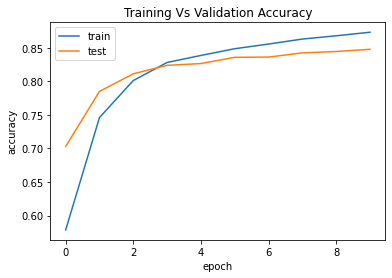

In [ ]:
# plot accuracy (train vs val)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Vs Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

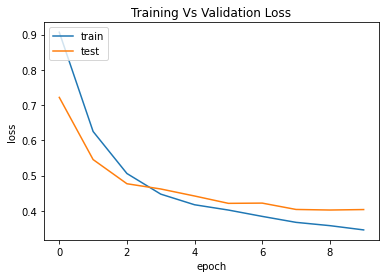

In [ ]:
# plot loss (train vs val)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Vs Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Bidirectional LTSM model

In [ ]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 50, input_length=max_len))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model2.add(layers.Dense(3,activation='softmax'))

model2.compile(optimizer=RMSprop(learning_rate=0.0001),loss='categorical_crossentropy', metrics=['accuracy'])
#Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("/content/drive/MyDrive/Ant_Thesis/Logs/best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=20,validation_data=(X_val, y_val),callbacks=[checkpoint2])

Epoch 1/20
471/471 [==============================] - ETA: 0s - loss: 1.0787 - accuracy: 0.3927
Epoch 1: val_accuracy improved from -inf to 0.39634, saving model to /content/drive/MyDrive/Ant_Thesis/Logs/best_model2.hdf5
471/471 [==============================] - 79s 156ms/step - loss: 1.0787 - accuracy: 0.3927 - val_loss: 1.0541 - val_accuracy: 0.3963
Epoch 2/20
471/471 [==============================] - ETA: 0s - loss: 1.0211 - accuracy: 0.4941
Epoch 2: val_accuracy improved from 0.39634 to 0.54690, saving model to /content/drive/MyDrive/Ant_Thesis/Logs/best_model2.hdf5
471/471 [==============================] - 71s 151ms/step - loss: 1.0211 - accuracy: 0.4941 - val_loss: 0.9823 - val_accuracy: 0.5469
Epoch 3/20
471/471 [==============================] - ETA: 0s - loss: 0.9550 - accuracy: 0.5701
Epoch 3: val_accuracy improved from 0.54690 to 0.58554, saving model to /content/drive/MyDrive/Ant_Thesis/Logs/best_model2.hdf5
471/471 [==============================] - 68s 145ms/step - los

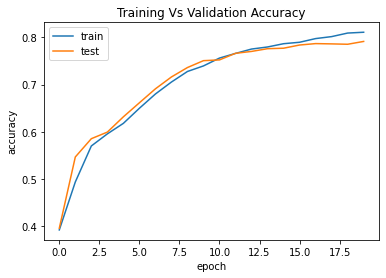

In [ ]:
# plot accuracy (train vs val)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Vs Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

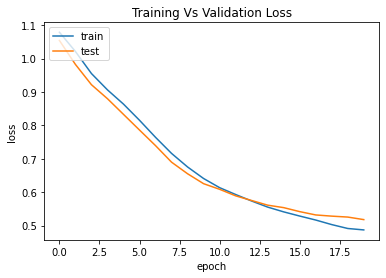

In [ ]:
# plot loss (train vs val)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Vs Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 1D Convolutional model

Before diving into this model, I know by prior experience that it tends to overfit extremely fast on small datasets. In this sense, just will implement it to show you how to do it in case it's of your interest.

In [ ]:
from keras import regularizers
model3 = Sequential()
model3.add(layers.Embedding(max_words, 40, input_length=max_len))
model3.add(layers.Conv1D(64, 7, activation='relu'))
model3.add(layers.MaxPooling1D(5))
model3.add(layers.Conv1D(32, 5, activation='relu'))
model3.add(layers.MaxPooling1D(2))
model3.add(layers.LSTM(16, return_sequences=True, dropout=0.3))
model3.add(layers.LSTM(8, dropout=0.2))
model3.add(layers.Dense(3,activation='softmax'))
model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history2 = model3.fit(X_train, y_train, epochs=30,validation_data=(X_val, y_val),callbacks=[checkpoint3])

Epoch 1/30
953/954 [============================>.] - ETA: 0s - loss: 1.0921 - accuracy: 0.4486
Epoch 1: val_accuracy improved from -inf to 0.45124, saving model to best_model3.hdf5
954/954 [==============================] - 50s 48ms/step - loss: 1.0921 - accuracy: 0.4484 - val_loss: 0.9930 - val_accuracy: 0.4512
Epoch 2/30
953/954 [============================>.] - ETA: 0s - loss: 1.0066 - accuracy: 0.4475
Epoch 2: val_accuracy did not improve from 0.45124
954/954 [==============================] - 44s 46ms/step - loss: 1.0067 - accuracy: 0.4474 - val_loss: 0.9928 - val_accuracy: 0.4512
Epoch 3/30
953/954 [============================>.] - ETA: 0s - loss: 1.0061 - accuracy: 0.4448
Epoch 3: val_accuracy did not improve from 0.45124
954/954 [==============================] - 44s 47ms/step - loss: 1.0062 - accuracy: 0.4448 - val_loss: 0.9932 - val_accuracy: 0.4512
Epoch 4/30
953/954 [============================>.] - ETA: 0s - loss: 1.0061 - accuracy: 0.4456
Epoch 4: val_accuracy did not

KeyboardInterrupt: ignored

If you check the val_accuracy metric in the training logs you won't find better score than the one achieved by the BidRNN. Again, the previous model is not the best for this task becaue is majorly used for short translation tasks, but the good thing to notice is its speed to train.

Let's move on.

# Best model validation
(Before final commit, the best model obtained was the BidRNN)

In [ ]:
#Let's load the best model obtained during training
best_model = keras.models.load_model("/content/Model_LSTM1.hdf5")

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

157/157 - 3s - loss: 1.6453 - accuracy: 0.4969 - 3s/epoch - 20ms/step
Model accuracy:  0.49691295623779297


In [ ]:
y_test

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
predictions = best_model.predict(X_test)

157/157 [==============================] - 5s 26ms/step


## Confusion matrix

Alright, we all know the accuracy is not a good metric to measure how well a model is. That's the reason why I like to always see its confusion matrix, that way I have a better understanding of its classification and generalization ability. Let's plot it.

In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

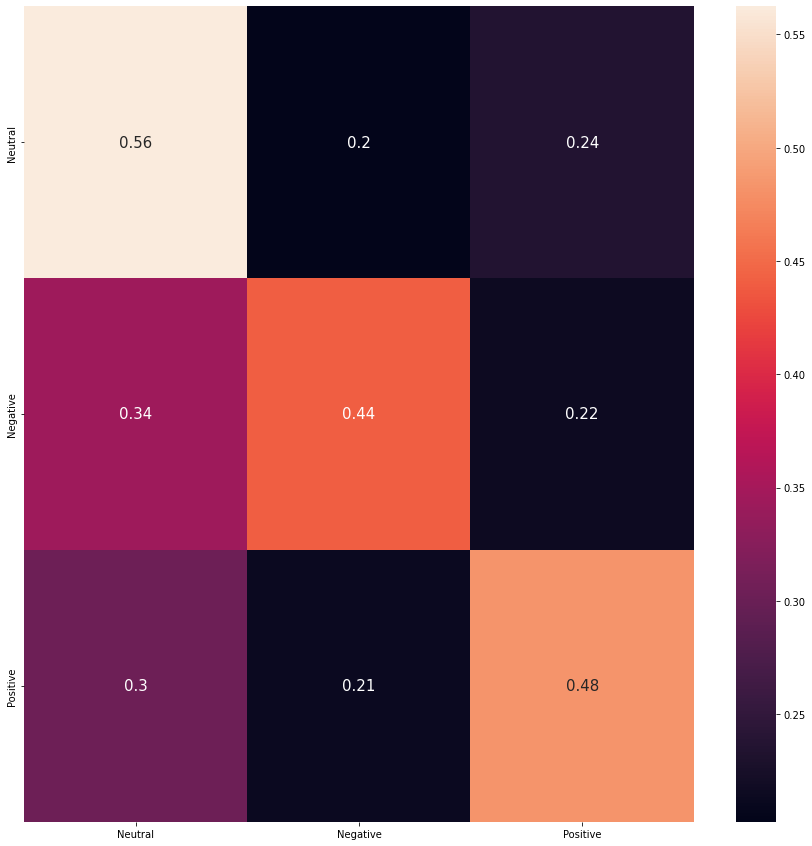

In [ ]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})

Again, the model's score is very poor, but keep in mind it hasn't gone through hyperparameter tuning. Let's see how it performs on some test text.

In [ ]:
sentiment = ['Neutral','Negative','Positive']

In [ ]:
sequence = tokenizer.texts_to_sequences(['bitcoin value decreased by 1% today, hurrah for altcoin'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 27ms/step


'Negative'

In [ ]:
sequence = tokenizer.texts_to_sequences(['this data science article is the best ever'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 31ms/step


'Positive'

In [ ]:
sequence = tokenizer.texts_to_sequences(['i hate youtube ads, they are annoying'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 32ms/step


'Negative'

In [ ]:
sequence = tokenizer.texts_to_sequences(['i really loved how the technician helped me with the issue that i had'])
test = pad_sequences(sequence, maxlen=max_len)
sentiment[np.around(best_model.predict(test), decimals=0).argmax(axis=1)[0]]

1/1 [==============================] - 0s 29ms/step


'Positive'

**Testing with test.csv**

In [ ]:
test['sentiment'].unique()

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [ ]:
test

,text,sentiment
0,RT Bitcoin Price Falls As Markets React To FAL...,Negative
1,RT 1 terabyte block capacity is coming to Bitc...,Neutral
2,bitcoin Is Record Business Optimism A Contrari...,Neutral
3,If you want private transactions use a privacy...,Neutral
4,As Novo Expects Bitcoin To Kill Other Crypto A...,Negative
...,...,...
5016,The Image MASSter Solo 101 Forensic Hard Drive...,Negative
5017,Buy Bitcoin Bitcoin Cash Monero Zcash or Litec...,Positive
5018,In April 2016 computer technicians at the Demo...,Neutral
5019,The Gentlemen of Crypto EP 129 Bitcoin Blackli...,Neutral


In [ ]:
test.rename(columns = {'text':'Cleaned_tweets'}, inplace = True)

In [ ]:
#Is there any null value?
test["text"].isnull().sum()

0

In [ ]:
t_temp = []
#Splitting pd.Series to list
data_to_list = test['text'].values.tolist()
for i in range(len(data_to_list)):
    t_temp.append(depure_data(data_to_list[i]))
list(t_temp[:5])

['RT Bitcoin Price Falls As Markets React To FALSE Japan Binance Threat UPDATED',
 'RT 1 terabyte block capacity is coming to Bitcoin Cash and can work while maintaining enough decentralization Joahannes',
 'bitcoin Is Record Business Optimism A Contrarian Indicator',
 'If you want private transactions use a privacy coin Bitcoin doesn t need to be the worlds next payment sy',
 'As Novo Expects Bitcoin To Kill Other Crypto Assets Altseason StillExpected']

In [ ]:
t_data_words = list(sent_to_words(t_temp))

print(t_data_words[:10])

[['rt', 'bitcoin', 'price', 'falls', 'as', 'markets', 'react', 'to', 'false', 'japan', 'binance', 'threat', 'updated'], ['rt', 'terabyte', 'block', 'capacity', 'is', 'coming', 'to', 'bitcoin', 'cash', 'and', 'can', 'work', 'while', 'maintaining', 'enough', 'joahannes'], ['bitcoin', 'is', 'record', 'business', 'optimism', 'contrarian', 'indicator'], ['if', 'you', 'want', 'private', 'transactions', 'use', 'privacy', 'coin', 'bitcoin', 'doesn', 'need', 'to', 'be', 'the', 'worlds', 'next', 'payment', 'sy'], ['as', 'novo', 'expects', 'bitcoin', 'to', 'kill', 'other', 'crypto', 'assets', 'altseason', 'stillexpected'], ['rt', 'free', 'bitcoin', 'litecoin', 'and', 'many', 'other', 'coin', 'mine', 'in', 'easy', 'way'], ['your', 'honesty', 'is', 'superb', 'we', 'would', 'have', 'liked', 'to', 'have', 'been', 'mooning', 'but', 'the', 'reality', 'is', 'years', 'jeez', 'people', 'bitcoin', 'took', 'years', 'lets', 'just', 'relax', 'we', 'are', 'onto', 'winner'], ['the', 'real', 'stark', 'industries

In [ ]:
len(t_data_words)

5021

In [ ]:
test_data = []
for i in range(len(t_data_words)):
    test_data.append(detokenize(t_data_words[i]))
print(test_data[:5])

['rt bitcoin price falls as markets react to false japan binance threat updated', 'rt terabyte block capacity is coming to bitcoin cash and can work while maintaining enough joahannes', 'bitcoin is record business optimism contrarian indicator', 'if you want private transactions use privacy coin bitcoin doesn need to be the worlds next payment sy', 'as novo expects bitcoin to kill other crypto assets altseason stillexpected']


In [ ]:
test_data = np.array(test_data)

In [ ]:
t_labels = np.array(test['sentiment'])
y_test = []

"""
for i in range(len(t_labels)):
    if t_labels[i] == 0:
        y_test.append(0)
    if t_labels[i] == -1:
        y_test.append(1)
    if t_labels[i] == 1:
        y_test.append(2)
"""

for i in range(len(t_labels)):
    if t_labels[i] == "Neutral":
        y_test.append(0)
    if t_labels[i] == "Negative":
        y_test.append(1)
    if t_labels[i] == "Positive":
        y_test.append(2)

y_test = np.array(y_test)
t_labels = tf.keras.utils.to_categorical(y_test, 3, dtype="float32")
del y_test

In [ ]:
len(t_labels)

5021

In [ ]:
test

,text,sentiment
0,RT Bitcoin Price Falls As Markets React To FAL...,Negative
1,RT 1 terabyte block capacity is coming to Bitc...,Neutral
2,bitcoin Is Record Business Optimism A Contrari...,Neutral
3,If you want private transactions use a privacy...,Neutral
4,As Novo Expects Bitcoin To Kill Other Crypto A...,Negative
...,...,...
5016,The Image MASSter Solo 101 Forensic Hard Drive...,Negative
5017,Buy Bitcoin Bitcoin Cash Monero Zcash or Litec...,Positive
5018,In April 2016 computer technicians at the Demo...,Neutral
5019,The Gentlemen of Crypto EP 129 Bitcoin Blackli...,Neutral


In [ ]:
t_labels

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
tokenizer.fit_on_texts(test_data)
sequences = tokenizer.texts_to_sequences(test_data)
t_tweets = pad_sequences(sequences, maxlen=max_len)
print(t_tweets)

[[   0    0    0 ...   72 1278 1205]
 [   0    0    0 ...  301  325  818]
 [   0    0    0 ...  207 4577 2661]
 ...
 [   0    0    0 ...  653   80    1]
 [   0    0    0 ... 1059   28  426]
 [   0    0    0 ...  405   73  118]]


In [ ]:
#Splitting the data
X_t_test, y_t_test = t_tweets, t_labels
print (len(X_t_test),len(y_t_test))

5021 5021


In [ ]:
t_predictions = best_model.predict(X_t_test)

157/157 [==============================] - 3s 17ms/step


In [ ]:
t_predictions.shape

(5021, 3)

In [ ]:
t_predictions = np.around(t_predictions, decimals=0)
y_true=np.argmax(y_t_test, axis=1)
y_pred=np.argmax(t_predictions, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score

print('Prediction Accuracy:', "{:.2f}".format(100*accuracy_score(y_true, y_pred))+"%")

Prediction Accuracy: 47.02%


In [ ]:
t_predictions

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
t_matrix = confusion_matrix(y_t_test.argmax(axis=1), np.around(t_predictions, decimals=0).argmax(axis=1))

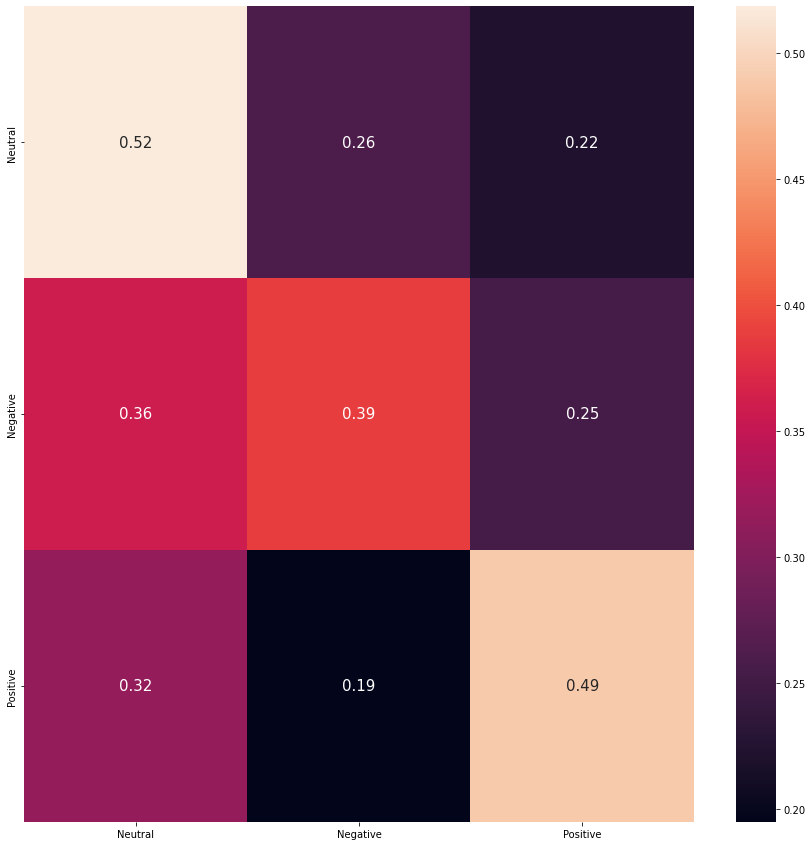

In [ ]:
conf_matrix = pd.DataFrame(t_matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 15})